# ⚡️ Training a spiking network with Torch

In [1]:
# -- Some useful imports

# - Rich printinghttp://localhost:8888/notebooks/torch-training.ipynb#
try:
    from rich import print
except:
    pass

# - Numpy
import numpy as np

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

## Considerations

## Define a task

We will define a simple random regression task, where random frozen input noise is mapped to randomly chosen smooth output signals. We implement this using a ``Dataset``-compatible class, implementing the ``__len__()`` and ``__getitem__()`` methods.

In [2]:
import torch

torch.manual_seed(0)
np.random.seed(0)
# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(
        self,
        num_classes: int = 2,
        sample_length: int = 100,
        input_channels: int = 50,
        target_channels: int = 2,
    ):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length

        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.0

        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = (
            np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        )

        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(
            2 * np.pi * self._target_omega * time_base + self._target_phase
        )

    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes

    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return torch.Tensor(self._inputs[i]), torch.Tensor(self._targets[i])

/home/mina/.pyenv/versions/3.8.7/envs/py3.8_torch1.12/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


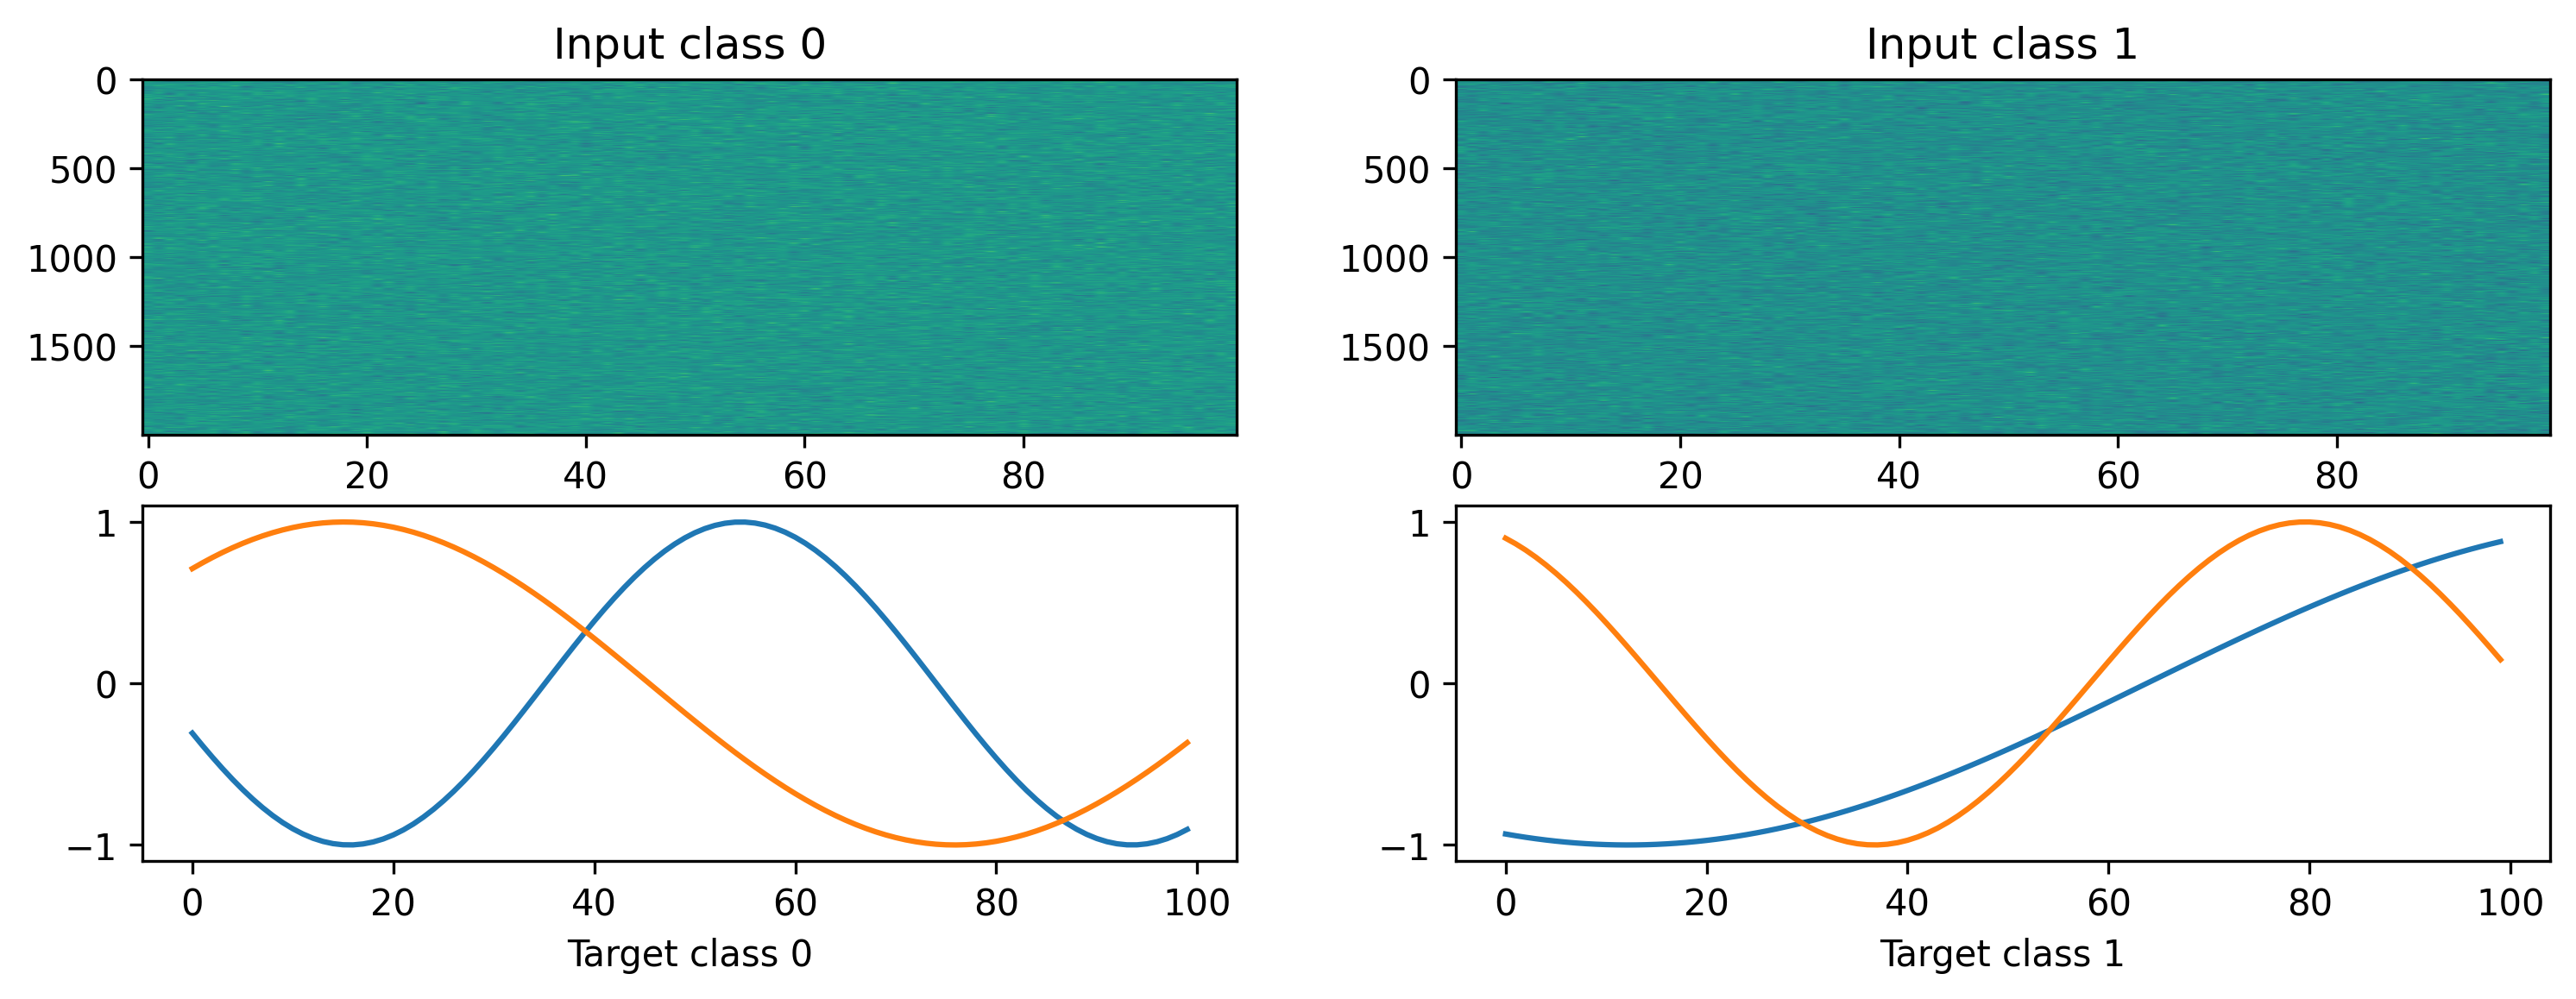

In [3]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 2
T = 100
ds = MultiClassRandomSinMapping(
    num_classes=num_classes,
    input_channels=Nin,
    target_channels=Nout,
    sample_length=T,
)

# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0].T, aspect="auto")
    plt.title(f"Input class {i}")

    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f"Target class {i}")

## Defining a network

We'll define a very simple MLP-like network to solve the regression task we just defined. In this simple network we define one hidden spiking layer. As regression with spiking output is very difficult, we also introduce a low-pass filter on the last layer. This allows the network to learn more or less smooth functions.

In [4]:
from rockpool.nn.modules import LinearTorch, ExpSynTorch, LIFTorch
from rockpool.nn.combinators import Sequential

np.random.seed(0)


def SimpleNet(Nin, Nhidden, Nout):
    return Sequential(
        LinearTorch((Nin, Nhidden), has_bias=False),
        LIFTorch(
            Nhidden,
            tau_mem=0.002,
            tau_syn=0.002,
            threshold=1.0,
            learning_window=0.2,
            dt=0.001,
        ),
        LinearTorch((Nhidden, Nout), has_bias=False),
        ExpSynTorch(Nout, dt=0.001, tau=0.01),
    )

In [5]:
Nhidden = 100

net = SimpleNet(Nin, Nhidden, Nout)
print(net)

TorchSequential  with shape (2000, 2) {
    LinearTorch '0_LinearTorch' with shape (2000, 100)
    LIFTorch '1_LIFTorch' with shape (100, 100)
    LinearTorch '2_LinearTorch' with shape (100, 2)
    ExpSynTorch '3_ExpSynTorch' with shape (2,)
}


## Training loop

As usually done for a regression task, we are using the MSE loss and Adam during training.
Everything works exactly the same as for the non-spiking layers with the exception that we are resetting the state of the neurons after each sample using the `detach` function.

In [6]:
# - Useful imports
from tqdm.autonotebook import tqdm
from torch.optim import Adam, SGD
from torch.nn import MSELoss

net = SimpleNet(Nin, Nhidden, Nout)

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-4)

# - Loss function
loss_fun = MSELoss()

# - Record the loss values over training iterations
loss_t = []

num_epochs = 10000

In [7]:
# - Loop over iterations
for _ in tqdm(range(num_epochs)):
    for input, target in ds:
        optimizer.zero_grad()

        output, state, recordings = net(input)

        loss = loss_fun(output, target)
        loss.backward()
        optimizer.step()

        # - Keep track of the loss
        loss_t.append(loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]/home/mina/.pyenv/versions/3.8.7/envs/py3.8_torch1.12/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 2])) that is different to the input size (torch.Size([1, 100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [13:30<00:00, 12.33it/s]


After training, we inspect the loss and plot the result of the training. We can see that the loss is decreasing and the predicted curves follow the target curves. The jitter is due to the discrete activations of the spiking layer and is expected. This could be reduced by using more hidden neurons and also training a bit longer would help. 

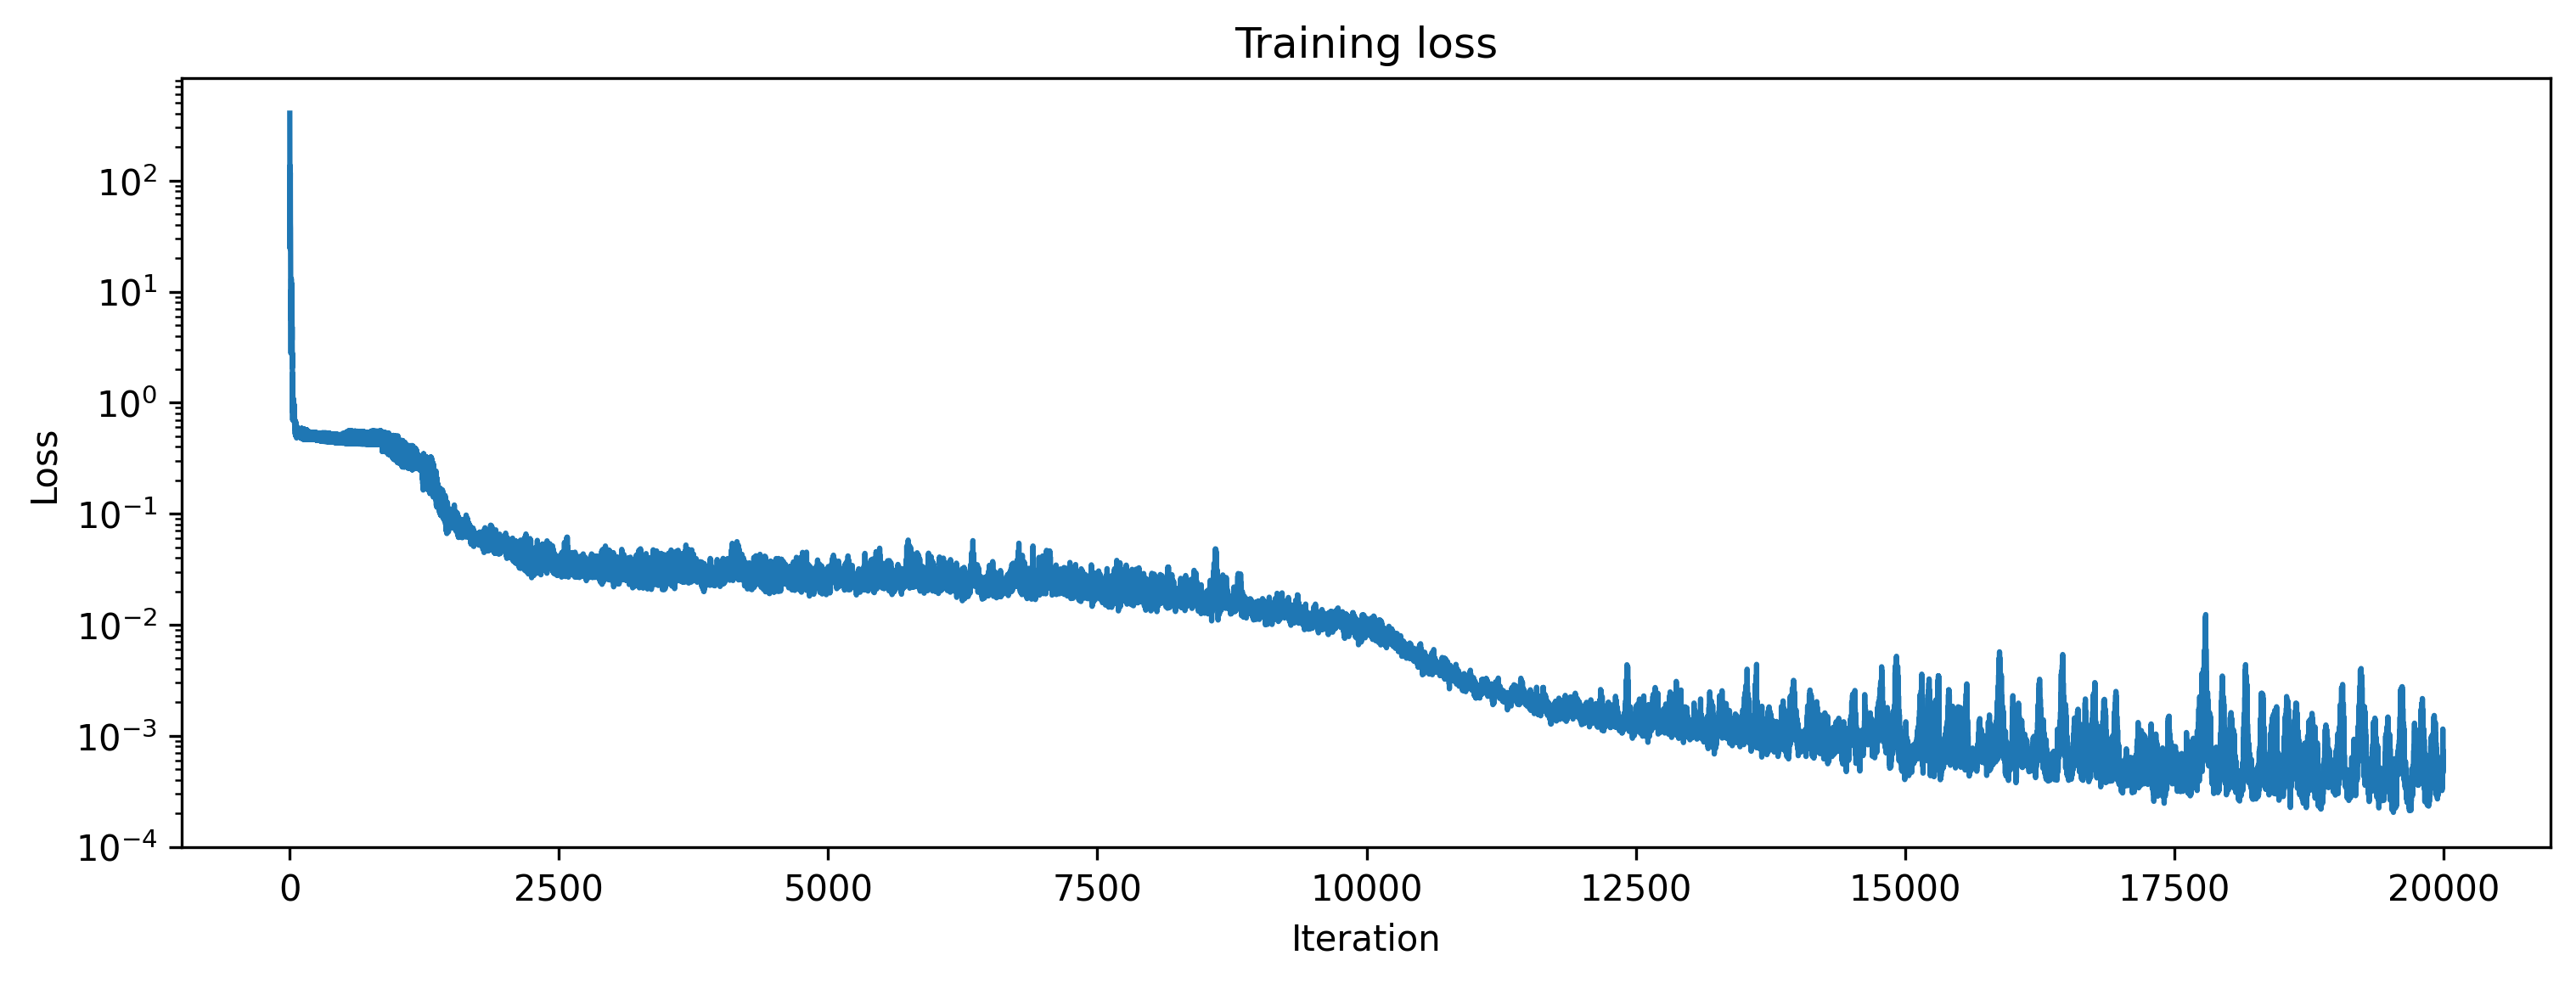

In [10]:
# - Plot the loss over iterations
plt.plot(loss_t)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training loss");

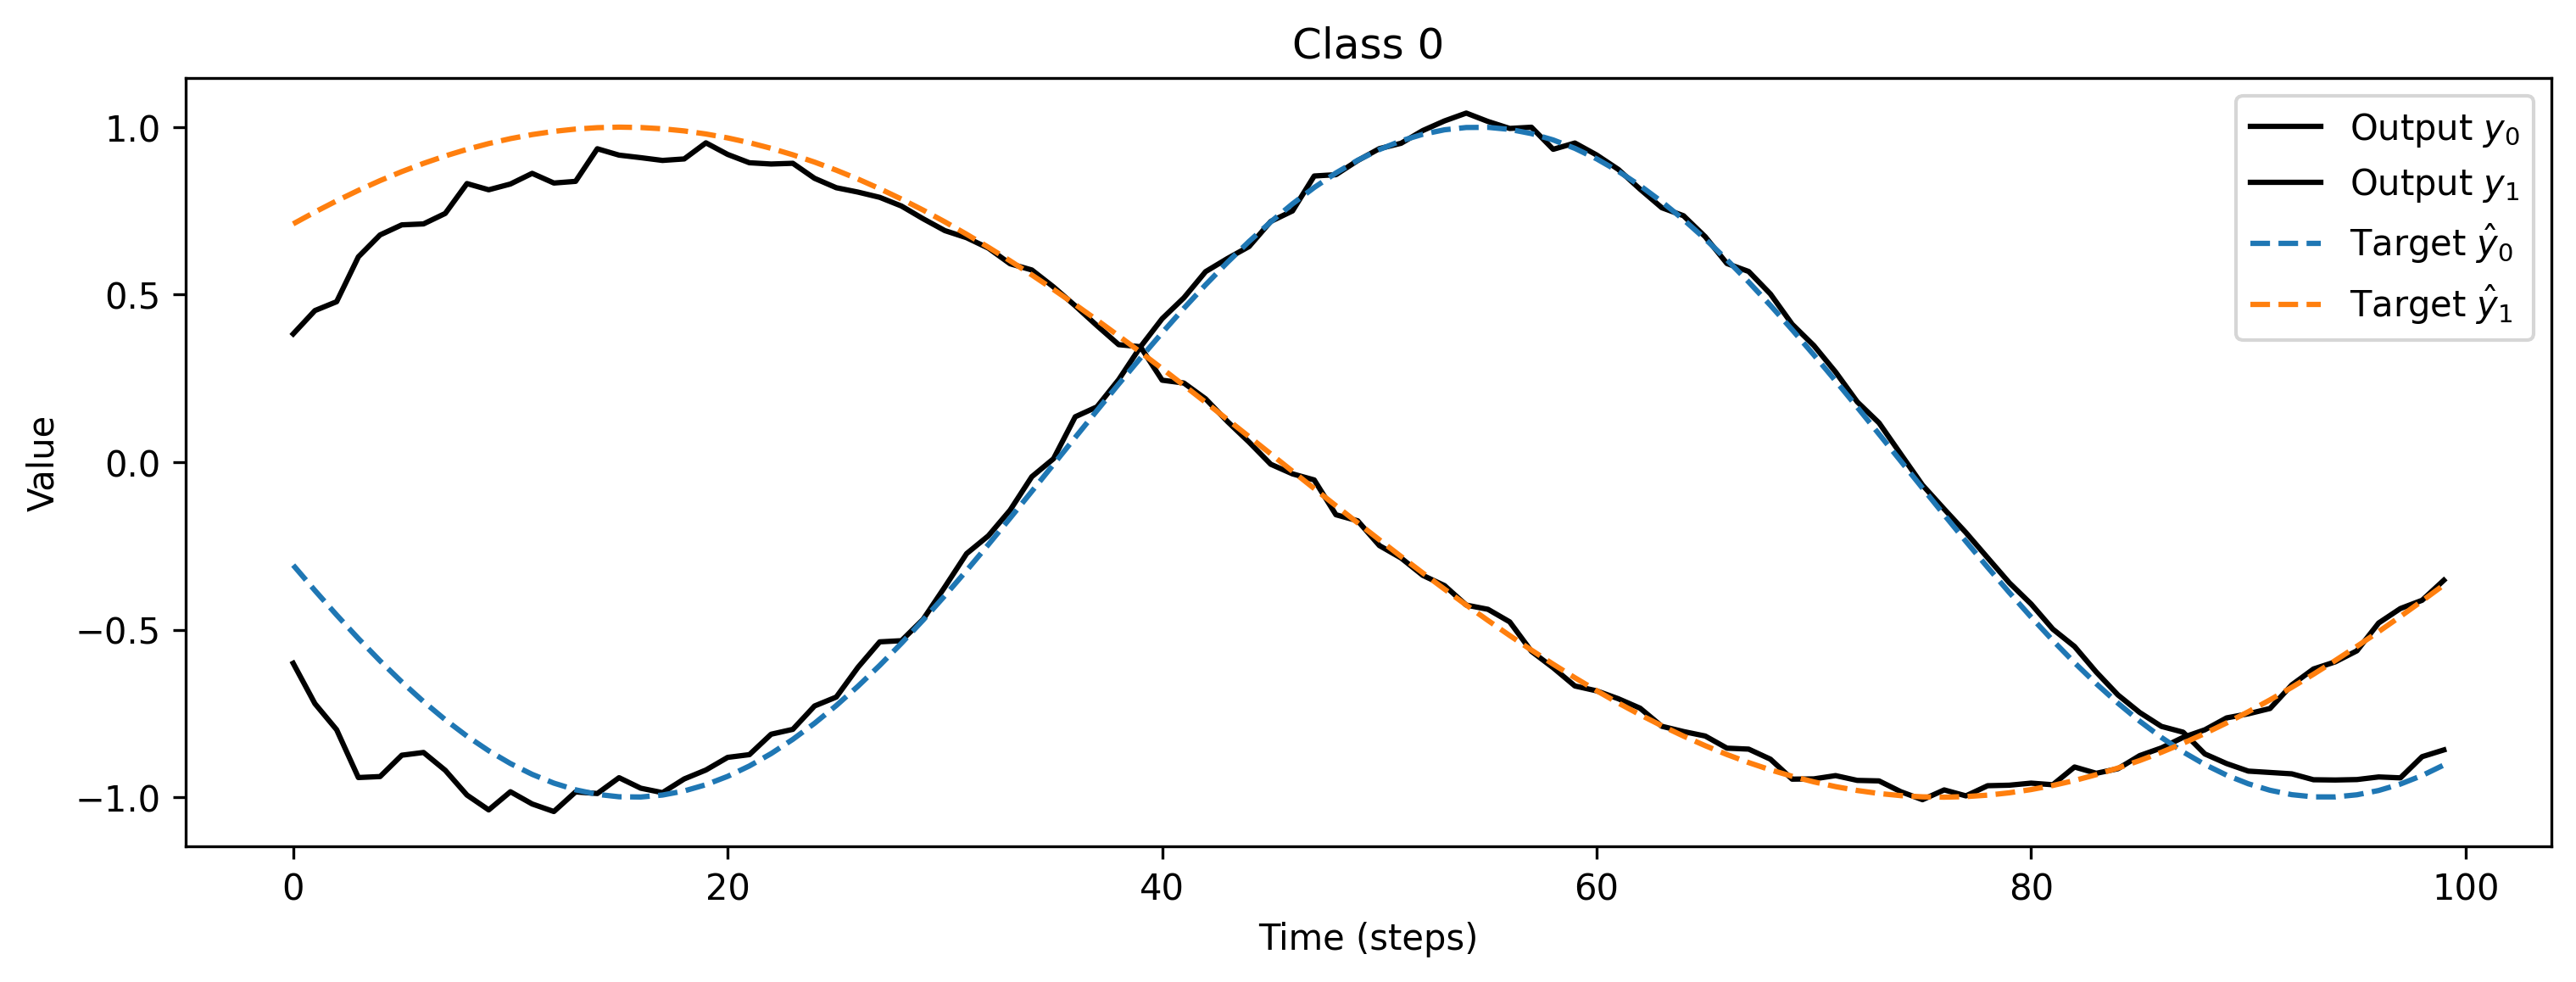

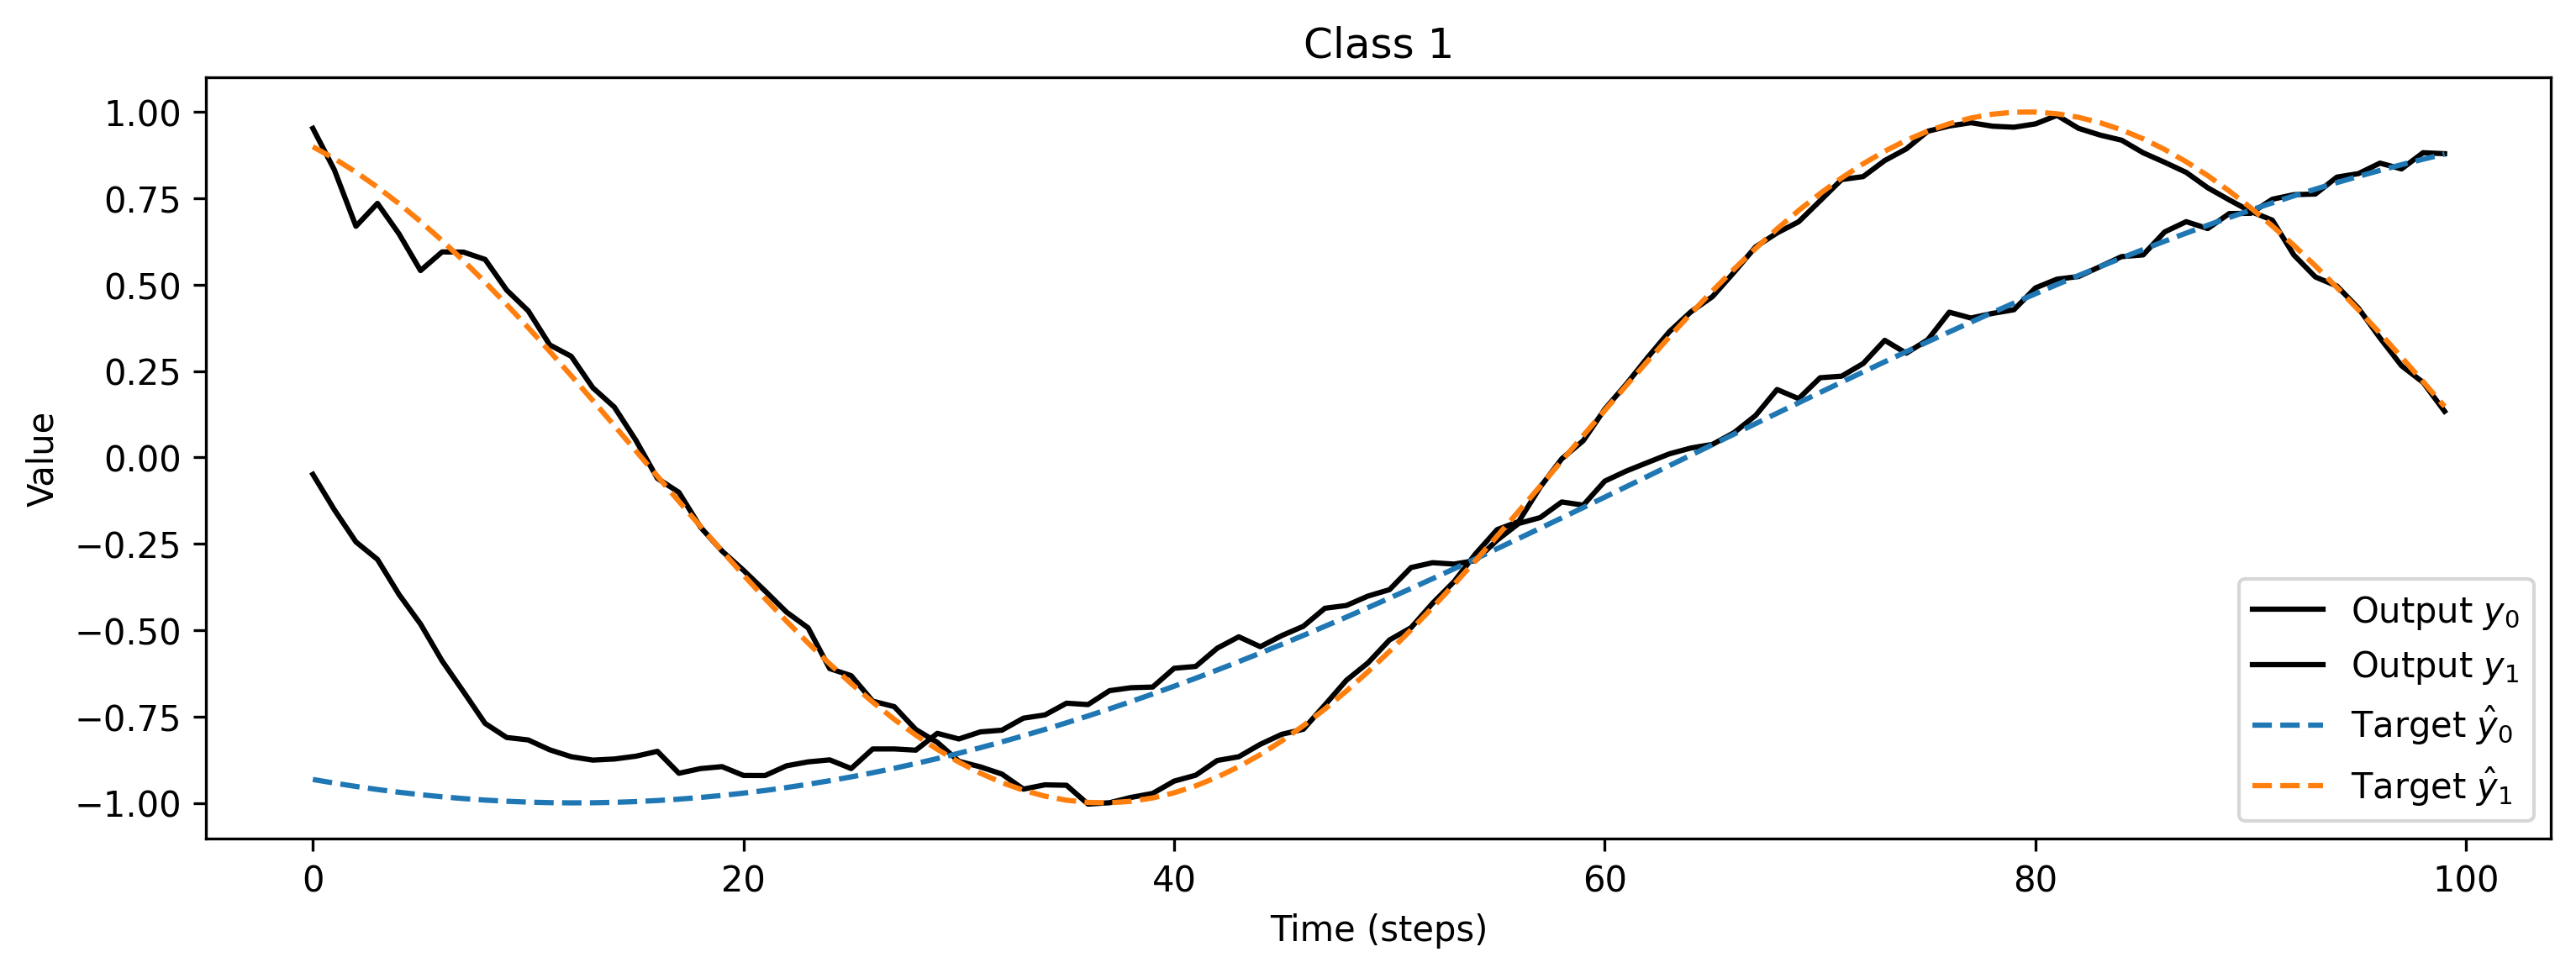

In [11]:
# - Evaluate classes
for i_class, [input, target] in enumerate(ds):

    # - Evaluate network
    net = net.reset_state()
    output, _, _ = net(input, record=True)

    # - Plot output and target
    plt.figure()
    plt.plot(output.detach().cpu().numpy()[0], "k-")
    plt.plot(target, "--")
    plt.xlabel("Time (steps)")
    plt.ylabel("Value")
    plt.legend(
        [
            "Output $y_0$",
            "Output $y_1$",
            "Target $\hat{y}_0$",
            "Target $\hat{y}_1$",
        ]
    )
    plt.title(f"Class {i_class}")

The spiking network has learned to reproduce the desired signals. Increasing the network size will reduce the error in reproduction, of course. The same approach can be applied to deeper networks, as well as recurrent networks.